In [1]:
%matplotlib inline


# 3D map analysis


## Context

While 1D spectral analysis is sufficient model a single point-source in the ON region, 3D analyses allow to consider complex field of views containing overlapping gamma-ray sources and model their respectibe morphologies.


## Proposed approach

In practice, we have to:

- Create a `~gammapy.data.DataStore` pointing to the relevant data
- Apply an observation selection to produce a list of observations,
  a `~gammapy.data.Observations` object.
- Define a geometry of the `~gammapy.datasets.MapDataset` we want to produce, with a sky projection
  and an energy range :
    - Create a `~gammapy.maps.MapAxis` for the energy
    - Create a `~gammapy.maps.WcsGeom` for the geometry
    
- Define the`~gammapy.modeling.models.Models` to apply to the dataset.
    - Load the known source from previous catalogues for example `gammapy.catalog.SourceCatalogHGPS`
    - Read one of the `gammapy.modeling.models.TemplateSpatialModel` provided for the diffuse emission
    - Use the known sources to create exclusion region map
  
- Create the necessary makers:

  - the map dataset maker `~gammapy.makers.MapDatasetMaker`
  - the background normalization maker, here a `~gammapy.makers.FoVBackgroundMaker` 
  - and usually the safe range maker : `~gammapy.makers.SafeMaskMaker`

- Perform the data reduction loop :
  - create a stacked `~gammapy.datasets.MapDataset` using the `~gammapy.makers.DatasetsMaskMaker`

- Make a TSmap using `~gammapy.estimators.TSMapEstimator`
- Create a `~gammapy.modeling.Fit` object and run it to fit the model
  parameters
- Use `~gammapy.estimators.utils.find_peaks_in_flux_map` to find new source candidates
- Fit, add new source models and re-fit until we get flat residual in the TSmap
- Usage of `~gammapy.modeling.select_nested_models` to compute significance for :
    - source detection
    - spectral curvature
    - spatial extension.


## Setup

First, we setup the analysis by performing required imports.


In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, Regions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

from gammapy.catalog import CATALOG_REGISTRY
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.estimators import TSMapEstimator
from gammapy.makers import FoVBackgroundMaker, MapDatasetMaker, SafeMaskMaker, DatasetsMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    GeneralizedGaussianSpatialModel
)
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_npred_signal

from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the
observations we want to analyse. Here we are going to use the simulated observations from CTA-1DC (first technical data challenge).


In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")

We can now define an observation filter to select only the relevant
observations. Here we use a cone search which we define with a python
dict.

We then filter the `ObservationTable` with
`~gammapy.data.ObservationTable.select_observations`.




In [4]:
selection = dict(
    type="sky_circle",
    frame="galactic",
    lon="0 deg",
    lat="0 deg",
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

display(selected_obs_table)

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
,deg,deg,deg,deg,deg,deg,deg,s,s,,s,s,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110380,267.68121338,-29.6075,359.9999912037958,-1.299995937905366,0.0,90.0,0,1800.0,1764.0,0.98000001907,664502400.0,664504192.0,2021-01-21,11:58:51,2021-01-21,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110380.fits,106217
111140,264.2315979,-29.5214,358.4999833830074,1.3000020211954284,0.0,90.0,0,1800.0,1764.0,0.98000001907,667958400.0,667960192.0,2021-03-02,11:58:51,2021-03-02,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_111140.fits,106386
111159,266.03671265,-26.9782,1.5000056568267741,1.299940468335294,0.0,90.0,0,1800.0,1764.0,0.98000001907,668044800.0,668046592.0,2021-03-03,11:58:51,2021-03-03,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_111159.fits,105741


We can now retrieve the relevant observations by passing their
``obs_id`` to the `~gammapy.data.DataStore.get_observations`
method.




In [5]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

Obs Id:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
observations[0].events

## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis, We choose a WCS
based geometry with a binsize of 0.02 deg and also define an energy
axis:




In [7]:
energy_axis = MapAxis.from_energy_bounds(0.3, 150.0, 10, unit="TeV", per_decade=True) #we could start at lower E

geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.03,
    width=(6, 4),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)
geom_image = geom.to_image()

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 200, 10, unit="TeV", name="energy_true", per_decade=True
)

Now we can define the target dataset with this geometry.




In [8]:
dataset_empty = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="gc-stacked"
)

## Prepare the models for known sources

First we load the H.E.S.S. Galactic plane survey (HGPS) source catalog

In [9]:
hgps = CATALOG_REGISTRY.get_cls("hgps")()

print(hgps)

SourceCatalogHGPS:
    name: hgps
    description: H.E.S.S. Galactic plane survey (HGPS) source catalog
    sources: 78



and select the sources inside our analysis region

In [10]:
hgps_models = hgps.to_models()
inside_geom = geom_image.contains(hgps_models.positions)
source_models = hgps_models[inside_geom]
print(source_models.names)

/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/Work/GitHub/gammapy/gammapy/modeling/models/spatial.py:655: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=COPY_IF_NEEDED)


['HESS J1741-302', 'HESS J1745-290', 'HESS J1745-303', 'HESS J1746-285', 'HESS J1746-308', 'HESS J1747-281']


## Prepare the models for known sources and diffuse emission 


Now we load an intersellar emission model  (IEM) created with https://github.com/cosmicrays/hermes for the CTA-GPS simulation https://zenodo.org/records/10008527. We added lighter versions in the repo so you can direclty read one of theses using `TemplateSpatialModel.read` method:


In [11]:
path = Path("./models/diffuse_template")
template_iem_base = TemplateSpatialModel.read(path / "IEM_base_20deg.fits.gz", normalize=False) 
template_varmin_rescaled = TemplateSpatialModel.read(path / "IEM_varmin_rescaled_20deg.fits.gz", normalize=False) 
#which one is the best suited for this simulation ? we will try later


These template are 3D maps so the `normalize=False` option is important to keep spectral information unchanged. 
We add that into a `SkyModel` together with a `PowerLawNormSpectralModel` that allows to refit the normalisation of the template.

In [12]:
iem_base = SkyModel(spatial_model=template_iem_base,
                            spectral_model=PowerLawNormSpectralModel(),
                            name="iem_base"
                           )
iem_varmin_rescaled = SkyModel(spatial_model=template_varmin_rescaled,
                               spectral_model=PowerLawNormSpectralModel(),
                               name="iem_varmin_rescaled"
                              )

## Data reduction


### Prepare exclusion mask

In order to scale the background model we have to mask the region with significant emission as explained in https://docs.gammapy.org/1.2/tutorials/api/mask_maps.html#creating-an-exclusion-mask

We start with know sources :


In [13]:
exclusion_radius = 0.3*u.deg # is it enough ? check psf 99% containment

source_regions = []
for source in source_models:
    radius = np.sqrt(exclusion_radius**2 + source.evaluation_radius**2)
    source_regions.append(CircleSkyRegion(source.position, radius)) 

We add a $\pm 1$ deg band to mask the contribution from diffuse emission in the Galactic plane

In [14]:
regions_ds9 = "galactic;box(0,0,20.0,2, 0)"
regions = list(Regions.parse(regions_ds9, format="ds9"))
print(regions)

[<RectangleSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>, width=20.0 deg, height=2.0 deg, angle=0.0 deg)>]


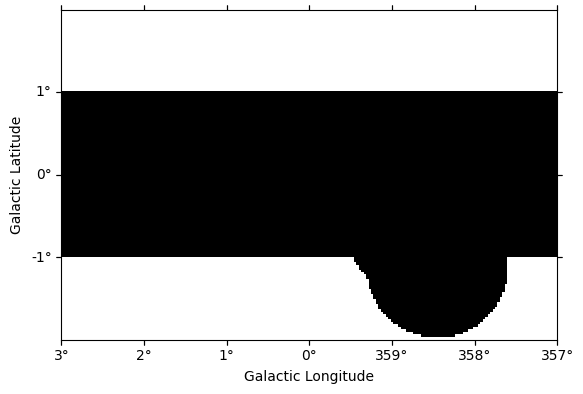

In [15]:
# to define the exclusion mask we take the inverse
exclusion_mask = ~geom_image.region_mask(regions+source_regions)
exclusion_mask.plot()
plt.show()


### Create the maker classes to be used

The `~gammapy.makers.MapDatasetMaker` object is initialized as well as
the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset
selection.



In [16]:
dataset_maker = MapDatasetMaker()
safe_mask_maker = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=5 * u.deg, aeff_percent=2
)

fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

makers = [dataset_maker, safe_mask_maker, fov_bkg_maker]  # the order matter


### Perform the data reduction




In [17]:
datasets_maker = DatasetsMaker(makers, stack_datasets=True, n_jobs=3)
datasets = datasets_maker.run(dataset_empty, observations)

print(datasets)

Data reduction:   0%|          | 0/3 [00:00<?, ?it/s]

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : gc-stacked
  Instrument : 
  Models     : 




## Save dataset to disk

It is common to run the preparation step independent of the likelihood
fit, because often the preparation of maps, PSF and energy dispersion is
slow if you have a lot of data. We first create a folder:




In [18]:
path = Path("datasets/cta1dc_gc/")
path.mkdir(exist_ok=True)

And then write the datasets to disk by calling the dedicated
`~gammapy.datasets.Datasets.write` method:




In [19]:
filename = path / "datasets_cta1dc_gc.yaml"
datasets.write(filename, overwrite=True)

### Inspect the reduced dataset




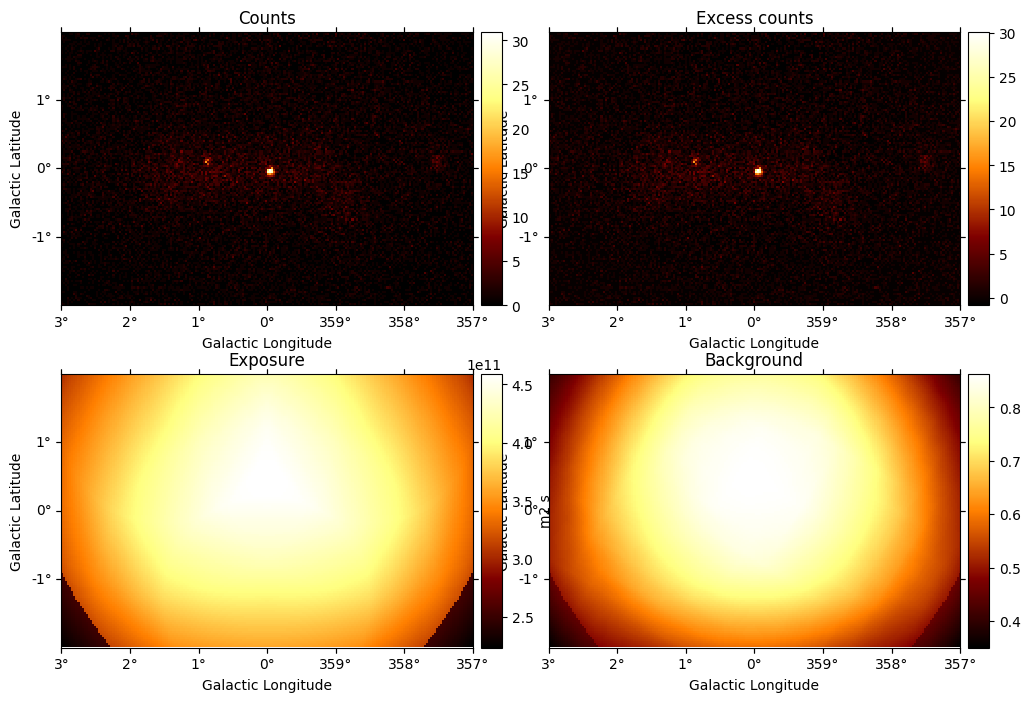

In [20]:
datasets[0].peek()

### Inspecting residuals

Let's quickly look at the excess above the background before adding models.
We have a few options on the dataset object to handle this. First we can use
`~gammapy.datasets.MapDataset.plot_residuals` to plot a residual image summed over all
energies and the spectral residuals in given region :




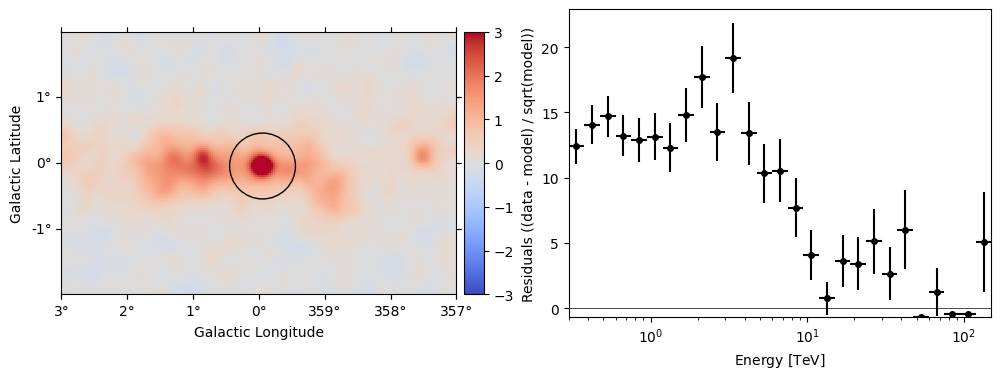

In [21]:
region = CircleSkyRegion(center=SkyCoord.from_name("Galactic Center"), radius=0.5 * u.deg)

axes = datasets[0].plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-3, vmax=3),
    kwargs_spectral=dict(method="diff/sqrt(model)", region=region),
)
plt.show()

We can make also use the `~gammapy.estimators.TSMapEstimator` get a map of the test statistic (TS) between two hypothesis : the best-fit flux model (assuming a given spatial shape and spectral index) and the null model (flux=0 i.e no source).

In [22]:
spatial_model = PointSpatialModel()
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

ts_estimator = TSMapEstimator(
    model,
    kernel_width="1. deg",#this set close to the 95-99% containment radius of the PSF
    selection_optional=[],
    #downsampling_factor=2,
    sum_over_energy_groups=True,
    energy_edges=[0.3, 150] * u.TeV,
)

In [23]:
%%time
ts_results = ts_estimator.run(datasets[0])

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Energy bins:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

TS map:   0%|          | 0/26600 [00:00<?, ?it/s]

CPU times: user 4.26 s, sys: 234 ms, total: 4.49 s
Wall time: 4.28 s


Let's define a function to make an objectively pretty plot

In [24]:
def plot_significance_map(estimator_results, source_models=None):
    fig = plt.figure(figsize=(13,5), dpi=130)
    ax = estimator_results["sqrt_ts"].plot(clim=[-6,6], cmap=plt.cm.RdBu_r)
    im = [obj for obj in ax.get_children() if isinstance(obj, mpl.image.AxesImage)][0]
    if source_models:
        source_models.plot_regions(ax=ax, edgecolor="g", linestyle="-", kwargs_point=dict(marker="."))
    plt.title(r"Significance", loc="left", fontsize=12, pad=15)
    cb_ax = fig.add_axes([.58, .91, .15, 0.04])
    cb = fig.colorbar(im, cax=cb_ax, orientation='horizontal')  
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.tick_params(axis="both", which="major", labelsize=12)
    cb.ax.set_xlabel(r"[$\sigma$]", fontsize=12, labelpad=-30, x=-0.09);

and plot the square root of TS map that can be considered as the detection significance

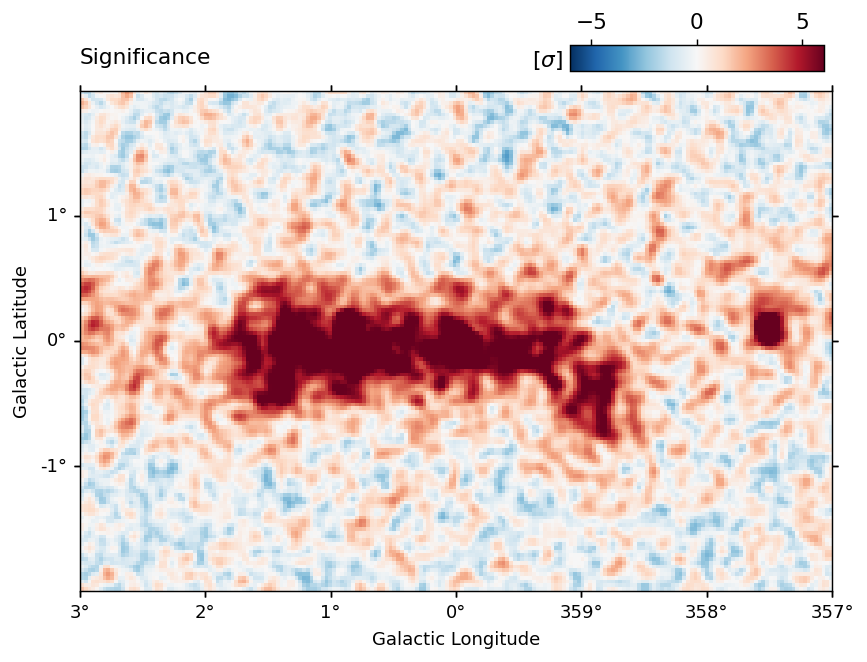

In [25]:
plot_significance_map(ts_results)

## Add the models to the datasets

We define a `FoVBackgroundModel` to rescale the background of each dataset 

In [26]:
bkg_models = Models([FoVBackgroundModel(dataset_name=d.name) for d in datasets])

and add these to the datasets with diffuse and sources models

In [27]:
datasets.models = source_models + bkg_models + [iem_base]
#datasets.models = source_models + bkg_models + [iem_varmin_rescaled]

Let's compute the residual significance map again

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Energy bins:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/37 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

TS map:   0%|          | 0/26600 [00:00<?, ?it/s]

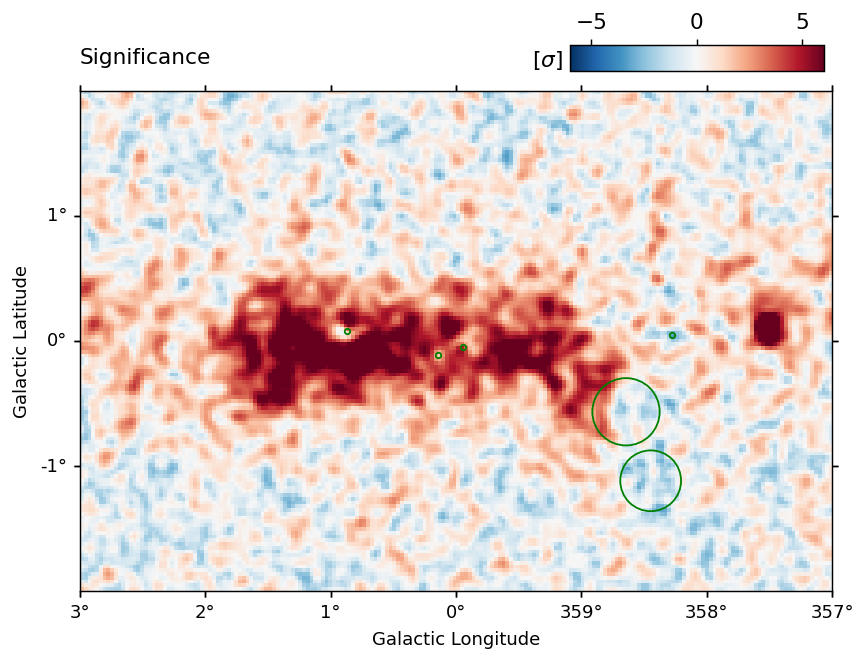

In [28]:
ts_results_known_sources_before_fit = ts_estimator.run(datasets[0])
plot_significance_map(ts_results_known_sources_before_fit, source_models)

The diffuse emission from the central molecular has to be reffited and some new sources seems to appears. \
So first we are going to do a fit of the known sources, and diffuse emission.
Then we are goind to add other sources iteratively.

In [29]:
#for now we freeze the parameters except the normalisation/amplitude : 
datasets.models.freeze()

for p in datasets.models.parameters:
    if p.name in ["norm", "amplitude"]:
        p.frozen = False
        p.min = 0
     
    # set some limit in case we want to fit the position later,
    # good to avoid the source to move outside of the region or switch places
    if p.name in ["lon_0", "lat_0"]:
        shift_max = 0.5
        p.max = p.value + shift_max
        p.min = p.value - shift_max


## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting
the ``stats`` method of the dataset to the minimizer. By default, it
uses ``iminuit``.

Its constructor takes a list of dataset as argument.




The fitted parameters are visible from the
`~astropy.modeling.models.Models` object.




Let's look at the residuals significance again

now we unfreeze the all parameters

We look for peak in the map using `~gammapy.estimators.utils.find_peaks_in_flux_map`
and display various parameters :



In [37]:
from gammapy.estimators.utils import find_peaks_in_flux_map

In [38]:
source_candidates = find_peaks_in_flux_map(ts_results_known_sources_fit_all, threshold=5, min_distance="0.25 deg")
display(source_candidates)

x,y,ra,dec,ts,norm,niter,norm_err,npred,npred_excess,stat,stat_null,success,flux,flux_err
,,deg,deg,,,,,,,,,,1 / (cm2 s),1 / (cm2 s)
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64
182,70,264.78172,-30.97639,85.54492,0.53342,9.0,0.08634,1144.67183,61.40122,2344.47452,2430.01943,True,1.775e-12,2.872e-13


let's create a new ` SkyModel` for this source candidate with a `GeneralizedGaussianSpatialModel` as spatial model and `LogParabolaSpectralModel` as spectral model.

In [39]:
def set_parameters_limits(model,
                          geom,
                          alpha_min=-1,
                          alpha_max=5,
                          beta_min=0,
                          beta_max=1,
                          shift_max=0.2,
                          r_fact=1,
                         ):

    dlb_max = max(geom.pixel_scales.value)
    lon_0 = model.parameters["lon_0"].value
    lat_0 = model.parameters["lat_0"].value
    r_0 = model.parameters["r_0"].value
    amp = model.parameters["amplitude"].value
    
    # parameters limits
    dlbr = shift_max + r_fact * r_0
    model.parameters["r_0"].min = np.maximum(dlb_max, r_0 - dlbr)
    model.parameters["r_0"].max = r_0 + dlbr
    model.parameters["lon_0"].min = lon_0 - dlbr
    model.parameters["lon_0"].max = lon_0 + dlbr
    model.parameters["lat_0"].min = lat_0 - dlbr
    model.parameters["lat_0"].max = lat_0 + dlbr

    model.parameters["alpha"].min = alpha_min
    model.parameters["alpha"].max = alpha_max
    model.parameters["beta"].min = beta_min
    model.parameters["beta"].max = beta_max
    model.parameters["amplitude"].min = 0.001 * amp
    model.parameters["amplitude"].max = 1000 * amp

def peak_to_model(glon, glat, radius, name, geom):
    spatial_model = GeneralizedGaussianSpatialModel(
        lon_0=glon,
        lat_0=glat,
        r_0=radius,
        eta=0.5,
        frame="galactic",
    ) 
    spatial_model.eta.min = 0.1
    
    spectral_model = LogParabolaSpectralModel(reference=1*u.TeV)
    
    model = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        datasets_names=None,
        name=name
    )
    set_parameters_limits(model, geom)
    return model


In [40]:
position = SkyCoord(source_candidates["ra"], source_candidates["dec"], frame="icrs").galactic
new_source = peak_to_model(position.l, position.b, 0.1*u.deg, name="Seed_0", geom=geom)

In [41]:
print(new_source)

SkyModel

  Name                      : Seed_0
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GeneralizedGaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.000   +/-    0.00             
    beta                          :      1.000   +/-    0.00             
    lon_0                         :    357.525   +/-    0.00 deg         
    lat_0                         :      0.120   +/-    0.00 deg         
    r_0                           :      0.100   +/-    0.00 deg         
    eta                           :      0.500   +/-    0.00             
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         




add it to the source list

and reset the models on the datasets

Guess what's come next ?\
Yes we are going to do another fit and plot the residual significance.\
To make it faster we fit only the new source first, and then everything.

We can plot the residual significance distribution compared to the expected normal distribution using `~gammapy.visualization.plot_distribution`

Let's plot all source spectral models

Here we can plot the number of predicted counts for each model and
for the background in our dataset. In order to do this, we can use
the `~gammapy.visualization.plot_npred_signal` function.




## Alternative hypothesis testing

First we are going to compute the detection significance using `~gammapy.modeling.select_nested_models` and remove the sources below 4 sigma


In [53]:
from gammapy.modeling import select_nested_models
from gammapy.stats.utils import ts_to_sigma

In [54]:
%%time
pbar.SHOW_PROGRESS_BAR = True
results = []
for model in pbar.progress_bar(source_models, desc="TS computation"):
    with source_models.parameters.restore_status(restore_values=True):
        # this `with` statement restores the source parameters after each fit
        # so the global model remain the same to estimate to detection significance of each source.
        
        # Number of parameters previously fit for the source of interest
        n_free_parameters = len(model.parameters.free_parameters)
        # Freeze spatial parameters to ensure another weaker source does not move from its position
        # to replace the source of interest during the null hypothesis test.
        # (with all parameters free you test N vs. N+1 models and not the detection of a specific source.)
        datasets.models.freeze(model_type='spatial')
        
        #for simplicity freeze the other sources and let only bkg and iem free (otherwise it takes 15 min).
        source_models.freeze()
        
        result = select_nested_models(datasets,
                                      parameters=[model.spectral_model.amplitude],
                                      null_values=[0],
                                      n_free_parameters=n_free_parameters,
                                      n_sigma=4,
                                      )
        result["name"] = model.name
        result["df"] = n_free_parameters
        result["sigma"] = ts_to_sigma(ts=result["ts"], df=n_free_parameters)
        results.append(result)
        print(model.name,
              f': ts={result["ts"]:.2f},',
              f'degree of freedom={n_free_parameters},',
              f'{result["sigma"]:.2f} sigma detection',
             )

TS computation:   0%|          | 0/7 [00:00<?, ?it/s]

HESS J1741-302 : ts=6.12, degree of freedom=4, 1.31 sigma detection
HESS J1745-290 : ts=841.52, degree of freedom=5, 28.58 sigma detection
HESS J1745-303 : ts=8.99, degree of freedom=5, 1.60 sigma detection
HESS J1746-285 : ts=9.94, degree of freedom=4, 2.04 sigma detection
HESS J1746-308 : ts=55.93, degree of freedom=5, 6.49 sigma detection
HESS J1747-281 : ts=166.29, degree of freedom=4, 12.33 sigma detection
Seed_0 : ts=124.36, degree of freedom=7, 10.05 sigma detection
CPU times: user 11.8 s, sys: 151 ms, total: 11.9 s
Wall time: 11.9 s


In [55]:
pbar.SHOW_PROGRESS_BAR = False

Some of the HESS sources are not significantly detected (we would need more observations or maybe they were not simulated). \
We can remove them from the models and reset the models on the dataset.

In [56]:
for result in results:
    if result["sigma"]<4:
        source_models.remove(result["name"])

In [57]:
datasets.models = source_models + bkg_models + [iem_base]

Now let's test the properties of the new source: 
- is the spectral curvature is significant ?
- is the extension significant ?

Again we can use `~gammapy.modeling.select_nested_models` \
But first we are going to freeze the other models for simplicity:

In [58]:
%%time
with datasets.models.restore_status(restore_values=False): #restore covariance and frozen status on exit
    for m in datasets.models:
        if m.name !=  new_source.name:
            m.freeze()

    result_curvature = select_nested_models(datasets,
                                  parameters=[new_source.spectral_model.beta],
                                  null_values=[0],
                                  n_sigma=2, #we set 2 sigma to switch to a more complex more
                                  )

    print("TS curvature", result_curvature["ts"])
    
    result_extension = select_nested_models(datasets,
                              parameters=[new_source.spatial_model.r_0],
                              null_values=[1e-2],# here we set very small radius (below the instrument resolution)
                              n_sigma=2,
                              )

    print("TS extension", result_extension["ts"])

TS curvature 1.204399467940675
TS extension 14.169855398067739
CPU times: user 16.5 s, sys: 247 ms, total: 16.8 s
Wall time: 16.8 s


In [59]:
new_source.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,amplitude,1.1011e-12,cm-2 s-1 TeV-1,0.000e+00,1.000e-15,1.000e-09,False,True,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
,alpha,2.5494e+00,,0.000e+00,-1.000e+00,5.000e+00,False,False,,
,beta,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,False,False,,
,lon_0,3.5752e+02,deg,0.000e+00,3.572e+02,3.578e+02,False,False,,
,lat_0,9.2789e-02,deg,0.000e+00,-1.800e-01,4.200e-01,False,False,,
,r_0,9.8817e-02,deg,0.000e+00,3.000e-02,4.000e-01,False,False,,
,eta,1.0000e-01,,0.000e+00,1.000e-01,1.000e+00,False,False,,
,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,,
